In [1]:
!pip install tensorflow==2.0

     |████████████████████████████████| 86.3MB 52kB/s 
     |████████████████████████████████| 3.8MB 55.4MB/s 
     |████████████████████████████████| 450kB 63.6MB/s 
     |████████████████████████████████| 81kB 13.2MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.1 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstall

Reproduced with code from this excellent [blog](https://towardsdatascience.com/faster-r-cnn-object-detection-implemented-by-keras-for-custom-data-from-googles-open-images-125f62b9141a)

In [7]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
from shutil import copyfile
import sys
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [8]:
tf.__version__

'2.0.0'

### Load data from .csv file

* `train-images-boxable.csv` file contains the image name and image url
* `train-annotations-bbox.csv` file contains the bounding box info with the image id (name) and the image label name
* `class-descriptions-boxable.csv` file contains the image label name corresponding to its class name

Download link:

https://storage.googleapis.com/openimages/web/download.html

https://www.figure-eight.com/dataset/open-images-annotated-with-bounding-boxes/

In [11]:
!python -m wget https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv


Saved under train-annotations-bbox.csv


In [12]:
!python -m wget https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv


Saved under train-images-boxable-with-rotation.csv


The original code used "***train-images-boxable.csv***" but I couldn't find it. So, I am using "***train-images-boxable-with-rotations.csv"***

In [13]:
!python -m wget https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv


Saved under class-descriptions-boxable.csv


In [14]:
images_boxable_fname = 'train-images-boxable-with-rotation.csv'
annotations_bbox_fname = 'train-annotations-bbox.csv'
class_descriptions_fname = 'class-descriptions-boxable.csv'

In [15]:
images_boxable = pd.read_csv(images_boxable_fname)
images_boxable.head()

ImageID Subset                                        OriginalURL  \
0  4fa8054781a4c382  train  https://farm3.staticflickr.com/5310/5898076654...   
1  b37f763ae67d0888  train  https://c1.staticflickr.com/1/67/197493648_628...   
2  7e8584b0f487cb9e  train  https://c7.staticflickr.com/8/7056/7143870979_...   
3  86638230febe21c4  train  https://farm5.staticflickr.com/5128/5301868579...   
4  249086e72671397d  train  https://c6.staticflickr.com/4/3930/15342460029...   

                                  OriginalLandingURL  \
0  https://www.flickr.com/photos/michael-beat/589...   
1  https://www.flickr.com/photos/drstarbuck/19749...   
2  https://www.flickr.com/photos/circasassy/71438...   
3  https://www.flickr.com/photos/ajcreencia/53018...   
4  https://www.flickr.com/photos/codnewsroom/1534...   

                                        License  \
0  https://creativecommons.org/licenses/by/2.0/   
1  https://creativecommons.org/licenses/by/2.0/   
2  https://creativecommons.org/licenses/by/2.0/   
3  https://creativecommons.org/licenses/by/2.0/   
4  https://creativecommons.org/licenses/by/2.0/   

                              AuthorProfileURL        Author  \
0  https://www.flickr.com/people/michael-beat/  Michael Beat   
1    https://www.flickr.com/people/drstarbuck/         Karen   
2    https://www.flickr.com/people/circasassy/    CircaSassy   
3    https://www.flickr.com/people/ajcreencia/          Alex   
4   https://www.flickr.com/people/codnewsroom/  COD Newsroom   

                                               Title  OriginalSize  \
0                                   ...die FNF-Kerze       4405052   
1                               Three boys on a hill        494555   
2  A Christmas carol and The cricket on the heart...       2371584   
3                                    Abbey and Kenny        949267   
4  Suburban Law Enforcement Academy 20th Annivers...       6541758   

                OriginalMD5  \
0  KFukvivpCM5QXl5SqKe41g==   
1  9IzEn38GRNsVpATuv7gzEA==   
2  3hQwu0iSzY1VIoXiwp0/Mg==   
3  onB+rCZnGQg5PRX7xOs18Q==   
4  MjpaAVbMAWbCusSaxI1D7w==   

                                    Thumbnail300KURL  Rotation  
0  https://c1.staticflickr.com/6/5310/5898076654_...       0.0  
1  https://c3.staticflickr.com/1/67/197493648_628...       0.0  
2  https://c7.staticflickr.com/8/7056/7143870979_...       0.0  
3  https://c4.staticflickr.com/6/5128/5301868579_...       NaN  
4  https://c1.staticflickr.com/4/3930/15342460029...       0.0

In [16]:
annotations_bbox = pd.read_csv(annotations_bbox_fname)
annotations_bbox.head()

ImageID  Source  LabelName  Confidence      XMin      XMax  \
0  000002b66c9c498e  xclick  /m/01g317           1  0.012500  0.195312   
1  000002b66c9c498e  xclick  /m/01g317           1  0.025000  0.276563   
2  000002b66c9c498e  xclick  /m/01g317           1  0.151562  0.310937   
3  000002b66c9c498e  xclick  /m/01g317           1  0.256250  0.429688   
4  000002b66c9c498e  xclick  /m/01g317           1  0.257812  0.346875   

       YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
0  0.148438  0.587500           0            1          0            0   
1  0.714063  0.948438           0            1          0            0   
2  0.198437  0.590625           1            0          0            0   
3  0.651563  0.925000           1            0          0            0   
4  0.235938  0.385938           1            0          0            0   

   IsInside  
0         0  
1         0  
2         0  
3         0  
4         0

1. **XMin, XMax, YMin, YMax**: coordinates of the box, in normalized image coordinates.
2. **IsOccluded**: Indicates that the object is occluded by another object in the image.
3. **IsTruncated**: Indicates that the object extends beyond the boundary of the image.
4. **IsGroupOf**: Indicates that the box spans a group of objects (e.g., a bed of flowers or a crowd of people). We asked annotators to use this tag for cases with more than 5 instances which are heavily occluding each other and are physically touching.
5. **IsDepiction**: Indicates that the object is a depiction (e.g., a cartoon or drawing of the object, not a real physical instance).
6. **IsInside**: Indicates a picture taken from the inside of the object (e.g., a car interior or inside of a building).


In [17]:
class_descriptions = pd.read_csv(class_descriptions_fname, header=None)
class_descriptions.head()

0           1
0    /m/011k07    Tortoise
1  /m/011q46kg   Container
2    /m/012074      Magpie
3    /m/0120dh  Sea turtle
4    /m/01226z    Football

### Plot Bounding box

In [18]:
def plot_bbox(img_id):
  img_url = images_boxable.loc[images_boxable["ImageID"]==img_id]['OriginalURL'].values[0]
  img = io.imread(img_url)
  height, width, channel = img.shape
  print(f"Image: {img.shape}")
  bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
  for index, row in bboxs.iterrows():
      xmin = row['XMin']
      xmax = row['XMax']
      ymin = row['YMin']
      ymax = row['YMax']
      xmin = int(xmin*width)
      xmax = int(xmax*width)
      ymin = int(ymin*height)
      ymax = int(ymax*height)
      label_name = row['LabelName']
      class_series = class_descriptions[class_descriptions[0]==label_name]
      class_name = class_series[1].values[0]
      print(f"Coordinates: {xmin,ymin}, {xmax,ymax}")
      cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 5)
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(img, class_name, (xmin,ymin-10), font, 3, (0,255,0), 5)
  plt.figure(figsize=(15,10))
  plt.title('Image with Bounding Box')
  plt.imshow(img)
  plt.axis("off")
  plt.show()

Finding images with lesser number of objects so as easy to visualize

In [19]:
least_objects_img_ids = annotations_bbox["ImageID"].value_counts().tail(50).index.values

Image: (667, 1000, 3)
Coordinates: (0, 0), (999, 666)


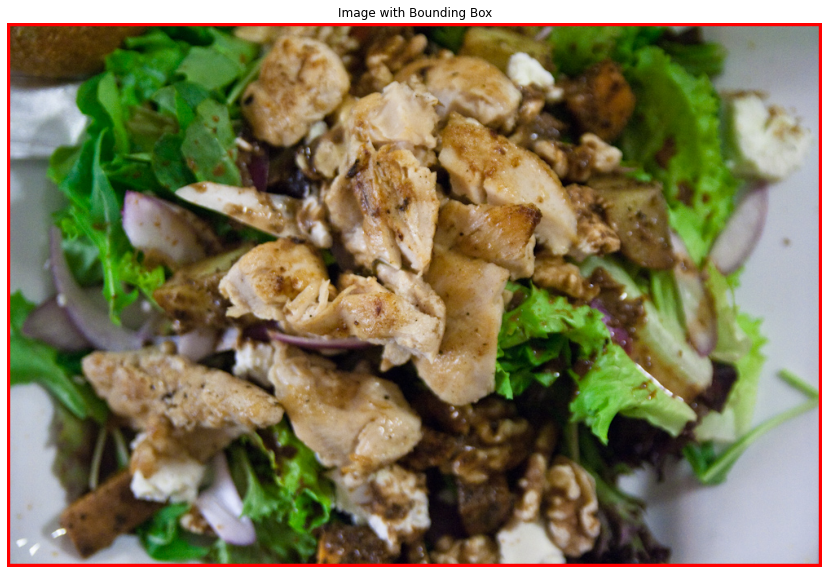

Image: (3264, 4896, 3)
Coordinates: (0, 627), (4892, 3260)


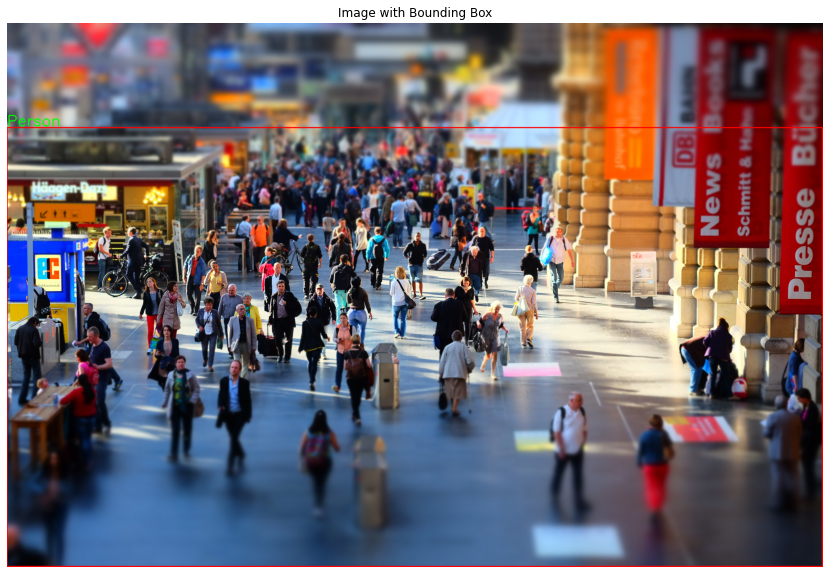

Image: (2212, 2931, 3)
Coordinates: (984, 632), (2756, 2096)


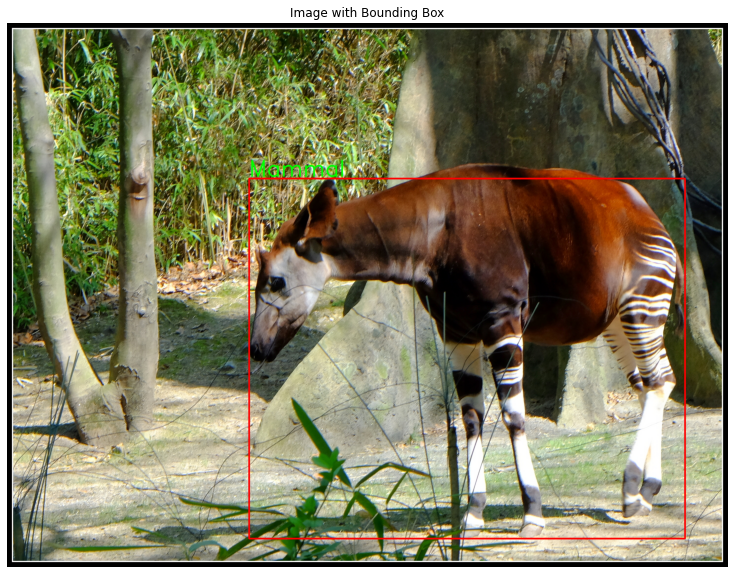

Image: (1024, 1024, 3)
Coordinates: (0, 0), (1018, 1022)


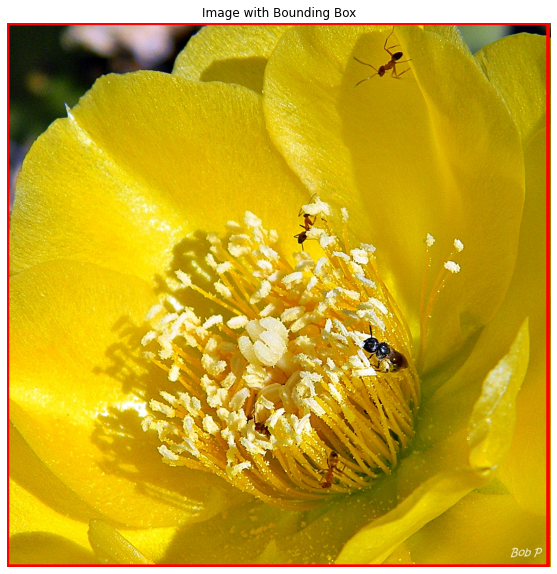

Image: (424, 272, 3)
Coordinates: (0, 0), (271, 423)


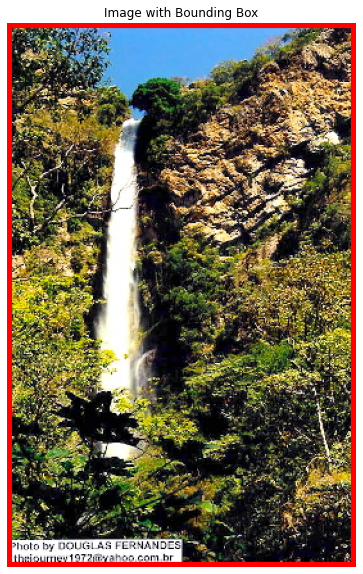

In [20]:
for img_id in random.sample(list(least_objects_img_ids), 5):
  plot_bbox(img_id)

### Get subset of the whole dataset

For here, I just want to detect three classes, which include person, mobile phone and car. We just extract 1000 images for each class from the whole dataset.

In [21]:
class_descriptions.loc[class_descriptions[1].isin(['Person', 'Mobile phone', 'Car'])]

0             1
68   /m/01g317        Person
312   /m/050k8  Mobile phone
570    /m/0k4j           Car

In [22]:
# Find the label_name for 'Person', 'Mobile Phone' and 'Car' classes
person_pd = class_descriptions[class_descriptions[1]=='Person']
phone_pd = class_descriptions[class_descriptions[1]=='Mobile phone']
car_pd = class_descriptions[class_descriptions[1]=='Car']

label_name_person = person_pd[0].values[0]
label_name_phone = phone_pd[0].values[0]
label_name_car = car_pd[0].values[0]

**Be careful that there might be several object in one image. For example, there are three person and two mobile phone in one image**

In [23]:
person_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_person]
phone_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_phone]
car_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_car]

In [24]:
print('There are %d persons in the dataset' %(len(person_bbox)))
print('There are %d phones in the dataset' %(len(phone_bbox)))
print('There are %d cars in the dataset' %(len(car_bbox)))
person_img_id = person_bbox['ImageID']
phone_img_id = phone_bbox['ImageID']
car_img_id = car_bbox['ImageID']

There are 1034721 persons in the dataset
There are 6365 phones in the dataset
There are 248075 cars in the dataset


In [25]:
person_img_id = np.unique(person_img_id)
phone_img_id = np.unique(phone_img_id)
car_img_id = np.unique(car_img_id)
print('There are %d images which contain persons' % (len(person_img_id)))
print('There are %d images which contain phones' % (len(phone_img_id)))
print('There are %d images which contain cars' % (len(car_img_id)))

There are 248384 images which contain persons
There are 4312 images which contain phones
There are 89465 images which contain cars


We just randomly pick 1000 images in here.

In [26]:
# here I've chosen only 10 images for speed, change it to your liking
n = 10
subperson_img_id = random.sample(list(person_img_id), n)
subphone_img_id = random.sample(list(phone_img_id), n)
subcar_img_id = random.sample(list(car_img_id), n)

In [27]:
subperson_pd = images_boxable.loc[images_boxable['ImageID'].isin(subperson_img_id)]
subphone_pd = images_boxable.loc[images_boxable['ImageID'].isin(subphone_img_id)]
subcar_pd = images_boxable.loc[images_boxable['ImageID'].isin(subcar_img_id)]

In [28]:
subperson_pd.shape

(10, 12)

In [29]:
subperson_pd.head()

ImageID Subset  \
100324  9997568bfbbc4a85  train   
486864  4b2e37e736de78fe  train   
634398  67cc0baede78a1f4  train   
636786  6f26710981a4bcd4  train   
639668  a72f3ace10a8f550  train   

                                              OriginalURL  \
100324  https://farm6.staticflickr.com/8189/8439348872...   
486864  https://c7.staticflickr.com/4/3133/2424210444_...   
634398  https://farm5.staticflickr.com/8111/8629624946...   
636786  https://farm5.staticflickr.com/5052/5428985933...   
639668  https://farm1.staticflickr.com/3133/2560138180...   

                                       OriginalLandingURL  \
100324  https://www.flickr.com/photos/lindsayjp/843934...   
486864  https://www.flickr.com/photos/joebeone/2424210444   
634398  https://www.flickr.com/photos/tipsfortraveller...   
636786  https://www.flickr.com/photos/stephanebarphoto...   
639668  https://www.flickr.com/photos/sunnycentralflor...   

                                             License  \
100324  https://creativecommons.org/licenses/by/2.0/   
486864  https://creativecommons.org/licenses/by/2.0/   
634398  https://creativecommons.org/licenses/by/2.0/   
636786  https://creativecommons.org/licenses/by/2.0/   
639668  https://creativecommons.org/licenses/by/2.0/   

                                         AuthorProfileURL          Author  \
100324           https://www.flickr.com/people/lindsayjp/    Peter-J-Pann   
486864            https://www.flickr.com/people/joebeone/        Joe Hall   
634398   https://www.flickr.com/people/tipsfortravellers/  Gary Bembridge   
636786   https://www.flickr.com/people/stephanebarphotos/    Stéphane Bar   
639668  https://www.flickr.com/people/sunnycentralflor...  VisitCentralFL   

                                              Title  OriginalSize  \
100324             valentine card scared black kids        499780   
486864    my busdriver playing a cool low-tech game       2242385   
634398  MSC Preziosa Naming Ceremony - Sophia Loren       4982466   
636786                                  John Kramer       5284710   
639668                                     DSC_0225       1515367   

                     OriginalMD5  \
100324  qlnHWMcCdnXjWitfoKSb7Q==   
486864  KuGG8kYYt3E7W42bYfii7g==   
634398  yIO87z9IYnHV/0D4Yhrb/Q==   
636786  jk5PjqzlJAzQVJhXKGeQlQ==   
639668  cumDLf66n014JLfda8MPeQ==   

                                         Thumbnail300KURL  Rotation  
100324  https://c4.staticflickr.com/9/8189/8439348872_...       0.0  
486864  https://c5.staticflickr.com/4/3133/2424210444_...       0.0  
634398  https://c1.staticflickr.com/9/8111/8629624946_...       0.0  
636786  https://c7.staticflickr.com/6/5052/5428985933_...       0.0  
639668  https://c6.staticflickr.com/4/3133/2560138180_...       0.0

In [30]:
subperson_dict = subperson_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subphone_dict = subphone_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subcar_dict = subcar_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()

In [31]:
# subperson_img_url = subperson_pd['OriginalURL'].tolist()
# subphone_img_url = subphone_pd['OriginalURL'].tolist()
# subcar_img_url = subcar_pd['OriginalURL'].tolist()

In [32]:
mappings = [subperson_dict, subphone_dict, subcar_dict]

In [33]:
len(mappings)

3

In [34]:
len(mappings[0])

10

In [35]:
classes = ['Person', 'Mobile phone', 'Car']

### Download images

We need to save the images with filename as `image id` with jpg extension

In [36]:
# download images
for idx, obj_type in enumerate(classes):
  n_issues = 0
  # create the directory
  if not os.path.exists(obj_type):
    os.mkdir(obj_type)
  for img_id, url in mappings[idx].items():
    try:
      img = io.imread(url)
      saved_path = os.path.join(obj_type, img_id+".jpg")
      io.imsave(saved_path, img)
    except Exception as e:
      n_issues += 1
  print(f"Images Issues: {n_issues}")

Images Issues: 0
Images Issues: 0
Images Issues: 2


In [38]:
!python -m ls Person | wc -l

'wc'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [83]:
!ls Mobile\ phone | wc -l

7


In [84]:
!ls Car | wc -l

9


### Dataset format for Faster-RCNN code

(fname_path, xmin, xmax, ymin, ymax, class_name)

train: 0.8
validation: 0.2

In [39]:
# save images to train and test directory
train_path = 'train'
test_path = 'test'

In [40]:
!mkdir train test

In [41]:
random.seed(1)

In [42]:
for i in range(len(classes)):
    all_imgs = os.listdir(classes[i])
    all_imgs = [f for f in all_imgs if not f.startswith('.')]
    random.shuffle(all_imgs)
    
    limit = int(n*0.8)

    train_imgs = all_imgs[:limit]
    test_imgs = all_imgs[limit:]
    
    # copy each classes' images to train directory
    for j in range(len(train_imgs)):
        original_path = os.path.join(classes[i], train_imgs[j])
        new_path = os.path.join(train_path, train_imgs[j])
        copyfile(original_path, new_path)
    
    # copy each classes' images to test directory
    for j in range(len(test_imgs)):
        original_path = os.path.join(classes[i], test_imgs[j])
        new_path = os.path.join(test_path, test_imgs[j])
        copyfile(original_path, new_path)

In [94]:
!ls train | wc -l

23


In [95]:
!ls test | wc -l

3


The expected number of training images and validation images should be 24 and 6 respectively.

However, there might be some overlap images which appear in two or three classes simultaneously. For instance, an image might be a person walking on the street and there are several cars in the street

In [43]:
label_names = [label_name_person, label_name_phone, label_name_car]

train_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# Find boxes in each image and put them in a dataframe
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]

for i in range(len(train_imgs)):
    sys.stdout.write('Parse train_imgs ' + str(i) + '; Number of boxes: ' + str(len(train_df)) + '\r')
    sys.stdout.flush()
    img_name = train_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                train_df = train_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)

In [44]:
train_df.head()

FileName      XMin      XMax      YMin      YMax     ClassName
0  040005e13c6019ee.jpg  0.000000  0.999120  0.112500  0.999375        Person
1  040005e13c6019ee.jpg  0.000000  0.482394  0.343750  0.800000  Mobile phone
2  040005e13c6019ee.jpg  0.400528  0.990317  0.516250  0.982500  Mobile phone
3  050e070e59758c2b.jpg  0.195625  0.442500  0.403333  0.837500        Person
4  050e070e59758c2b.jpg  0.531875  0.746250  0.417500  0.750000        Person

In [45]:
train_df.shape

(69, 6)

Let's test if they work fine by plotting the bounding box for the above 5 images

In [46]:
train_img_ids = train_df["FileName"].head().str.split(".").str[0].unique()

Image: (1700, 1208, 3)
Coordinates: (0, 191), (1206, 1698)
Coordinates: (0, 584), (582, 1360)
Coordinates: (483, 877), (1196, 1670)


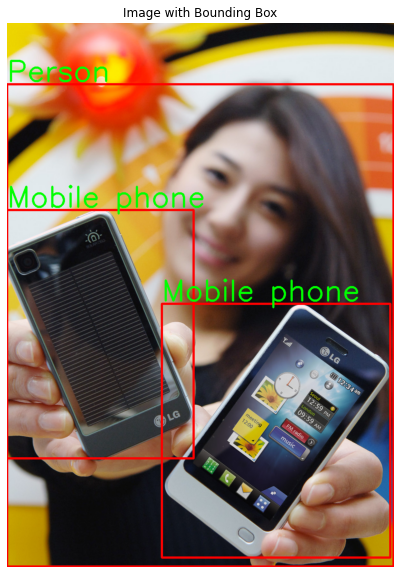

Image: (3000, 4000, 3)
Coordinates: (650, 1727), (1432, 2555)
Coordinates: (782, 1209), (1770, 2512)
Coordinates: (2127, 1252), (2985, 2250)
Coordinates: (2652, 1257), (3200, 2192)
Coordinates: (3330, 1292), (3997, 2130)
Coordinates: (1312, 1587), (2000, 2367)
Coordinates: (2052, 1577), (2727, 2222)
Coordinates: (2552, 1542), (3197, 2172)
Coordinates: (3235, 1557), (3880, 2124)
Coordinates: (0, 0), (3997, 2997)
Coordinates: (1372, 2370), (1615, 2514)
Coordinates: (1547, 2195), (1802, 2282)
Coordinates: (1947, 2214), (2187, 2345)
Coordinates: (2055, 1982), (2272, 2154)
Coordinates: (2597, 2145), (2727, 2227)
Coordinates: (2782, 1922), (3000, 2019)
Coordinates: (2960, 2060), (3207, 2165)
Coordinates: (3707, 2040), (3790, 2132)
Coordinates: (3895, 1827), (3997, 1922)


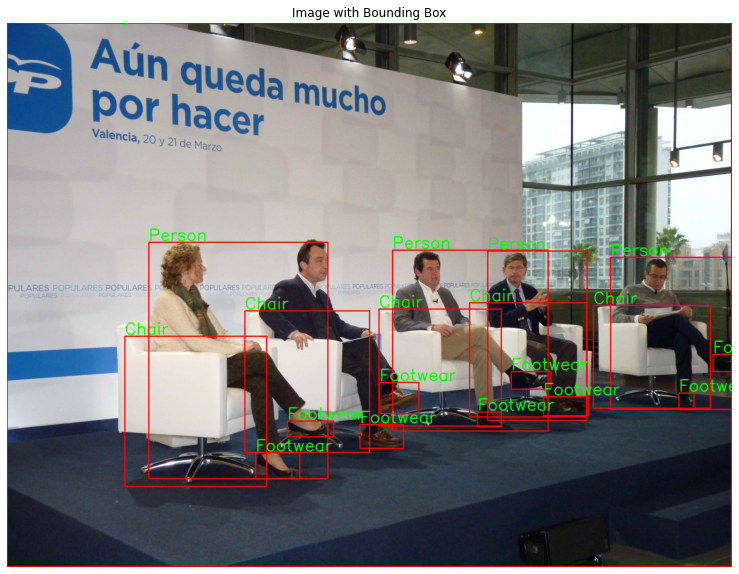

In [47]:
for img_id in train_img_ids:
  plot_bbox(img_id)

**This looks fine to me!!**

In [48]:
val_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# find boxes in each image and put them in a dataframe
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]

for i in range(len(test_imgs)):
    sys.stdout.write('Parse test_imgs ' + str(i) + '; Number of boxes: ' + str(len(test_df)) + '\r')
    sys.stdout.flush()
    img_name = test_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                val_df = val_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)

NameError: name 'test_df' is not defined

In [0]:
train_df.to_csv('train.csv')
test_df.to_csv('test.csv')

### Write train.csv to annotation.txt

In [0]:
train_df = pd.read_csv('train.csv')

# for training
with open("annotation.txt", "w+") as f:
  for idx, row in train_df.iterrows():
      img = cv2.imread('train/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)
      
      google_colab_file_path = 'drive/My Drive/AI/Dataset/Open Images Dataset v4 (Bounding Boxes)/train'
      fileName = os.path.join(google_colab_file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

In [49]:
test_df = pd.read_csv('test.csv')

# for test
with open("test_annotation.txt", "w+") as f:
  for idx, row in test_df.iterrows():
      sys.stdout.write(str(idx) + '\r')
      sys.stdout.flush()
      img = cv2.imread('test/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)
      
      google_colab_file_path = 'drive/My Drive/AI/Dataset/Open Images Dataset v4 (Bounding Boxes)/test'
      fileName = os.path.join(google_colab_file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

FileNotFoundError: [Errno 2] No such file or directory: 'test.csv'